# Building a RNN on SMILES data

In [200]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [220]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pickle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

%run ../assets/accuracy_loss_plots.py # function to plot accuracy and loss
%run ../assets/confusion_matrix.py # function to plot accuracy and loss
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

## Read in data

In [221]:
df = pd.read_csv("../data/CID_properties_nr.csv")

In [222]:
# lowercase column names
df.columns = df.columns.str.lower()

In [223]:
# remove extra classes
index_names = df[(df["drug_class"] == "antineoplastic") | (df["drug_class"] == "cns") | (df["drug_class"] == "cardio")].index

df = df.loc[index_names]

In [224]:
df["drug_class"].value_counts()

antineoplastic    1174
cns               1141
cardio             787
Name: drug_class, dtype: int64

## Set up X and y variables

In [225]:
# Make my drug class variable categorical

In [226]:
classes_dict = {
    "antineoplastic": 0,
    "cns": 1,
    "cardio": 2}

In [227]:
# map drug classes to numerical
df['drug_class'] = df['drug_class'].map(classes_dict)
df.head()

,cid,hbondacceptorcount,hbonddonorcount,isomericsmiles,molecularweight,xlogp,drug_class,desalted_smiles
1,134694070,9,6,C1CN=C(N1)NC2=C(C3=NC=CN=C3C=C2)Br.[C@@H](C(C(...,442.226,NaN,2,Brc1c(NC2=NCCN2)ccc2nccnc12
3,4660557,1,1,C1C2CC3CC1CC(C2)C3NC4=CC=C(C=C4)Br,306.247,5.0,1,Brc1ccc(NC2C3CC4CC(C3)CC2C4)cc1
4,122175,2,2,CC(CCC(C#C)N)N,126.203,-0.4,0,C#CC(N)CCC(C)N
5,5281077,1,1,CCC(/C=C/Cl)(C#C)O,144.598,1.5,1,C#CC(O)(/C=C/Cl)CC
12,92913,1,1,CC(CC1=CC=CC=C1)N(C)CC#C.Cl,223.744,NaN,1,C#CCN(C)C(C)Cc1ccccc1


In [228]:
# check that the values are still the same
df["drug_class"].value_counts()

0    1174
1    1141
2     787
Name: drug_class, dtype: int64

In [239]:
X

1                Brc1c(NC2=NCCN2)ccc2nccnc12
3            Brc1ccc(NC2C3CC4CC(C3)CC2C4)cc1
4                             C#CC(N)CCC(C)N
5                         C#CC(O)(/C=C/Cl)CC
12                     C#CCN(C)C(C)Cc1ccccc1
                        ...                 
6929             c1ccc2c(c1)OCC(CN1CCCCC1)O2
6931    c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1
6932                      c1cnc(N2CCNCC2)nc1
6933             c1csc(C2(N3CCCCC3)CCCCC2)c1
6934               c1csc(C2CCCCN2C2CCCCC2)c1
Name: desalted_smiles, Length: 3102, dtype: object

In [229]:
# set up my X and y variables
X = df["desalted_smiles"]
y = df["drug_class"]

In [230]:
# y = to_categorical(y)

In [231]:
# Split my train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, random_state = 42)

## Preprocess Text

In [232]:
# set up tokenizer
tokenizer = Tokenizer(char_level=True, lower = False )
tokenizer.fit_on_texts(df["desalted_smiles"])
sequence_of_int = tokenizer.texts_to_sequences(df["desalted_smiles"])

In [233]:
X_train_tk = tokenizer.texts_to_matrix(X_train, mode='count' )
X_test_tk = tokenizer.texts_to_matrix(X_test, mode='count' )

In [234]:
# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 50 unique tokens.


In [235]:
# tokenizer keeps the special characters by default! 
# This is useful for me since the special characters have significance in SMILES
word_index

{'C': 1,
 'c': 2,
 '(': 3,
 ')': 4,
 'O': 5,
 '@': 6,
 '1': 7,
 '[': 8,
 ']': 9,
 '=': 10,
 'H': 11,
 'N': 12,
 '2': 13,
 '3': 14,
 'n': 15,
 '4': 16,
 '/': 17,
 '5': 18,
 '-': 19,
 'S': 20,
 'l': 21,
 'F': 22,
 '+': 23,
 '6': 24,
 '\\': 25,
 '.': 26,
 'P': 27,
 '#': 28,
 's': 29,
 'o': 30,
 '7': 31,
 'B': 32,
 'r': 33,
 '8': 34,
 't': 35,
 'I': 36,
 '9': 37,
 'e': 38,
 'A': 39,
 'G': 40,
 'm': 41,
 'M': 42,
 '%': 43,
 '0': 44,
 'i': 45,
 'T': 46,
 'u': 47,
 'a': 48,
 'b': 49,
 'X': 50}

# Build model

In [236]:
model = Sequential()
model.add(Embedding(500,32))
model.add(SimpleRNN(51))
model.add(Dense(3, activation = "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          16000     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 51)                4284      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 156       
Total params: 20,440
Trainable params: 20,440
Non-trainable params: 0
_________________________________________________________________


In [237]:
model.compile(optimizer = "adam", loss =  "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [238]:
history = model.fit(X_train_tk, y_train,
                   epochs = 30,
                   batch_size = 128, 
                   validation_data = (X_test_tk, y_test))

Train on 2326 samples, validate on 776 samples
Epoch 1/30
2326/2326 [==============================] - 1s 532us/sample - loss: 1.0511 - accuracy: 0.4493 - val_loss: 1.0084 - val_accuracy: 0.5155
Epoch 2/30
2326/2326 [==============================] - 0s 170us/sample - loss: 0.9752 - accuracy: 0.5400 - val_loss: 0.9761 - val_accuracy: 0.5232
Epoch 3/30
2326/2326 [==============================] - 0s 170us/sample - loss: 0.9349 - accuracy: 0.5606 - val_loss: 0.9519 - val_accuracy: 0.5348
Epoch 4/30
2326/2326 [==============================] - 0s 152us/sample - loss: 0.9145 - accuracy: 0.5813 - val_loss: 0.9398 - val_accuracy: 0.5580
Epoch 5/30
2326/2326 [==============================] - 0s 152us/sample - loss: 0.9007 - accuracy: 0.5911 - val_loss: 0.9456 - val_accuracy: 0.5683
Epoch 6/30
2326/2326 [==============================] - 0s 152us/sample - loss: 0.8897 - accuracy: 0.6122 - val_loss: 0.9220 - val_accuracy: 0.5747
Epoch 7/30
2326/2326 [==============================] - 0s 146us/

### Evaluate Model

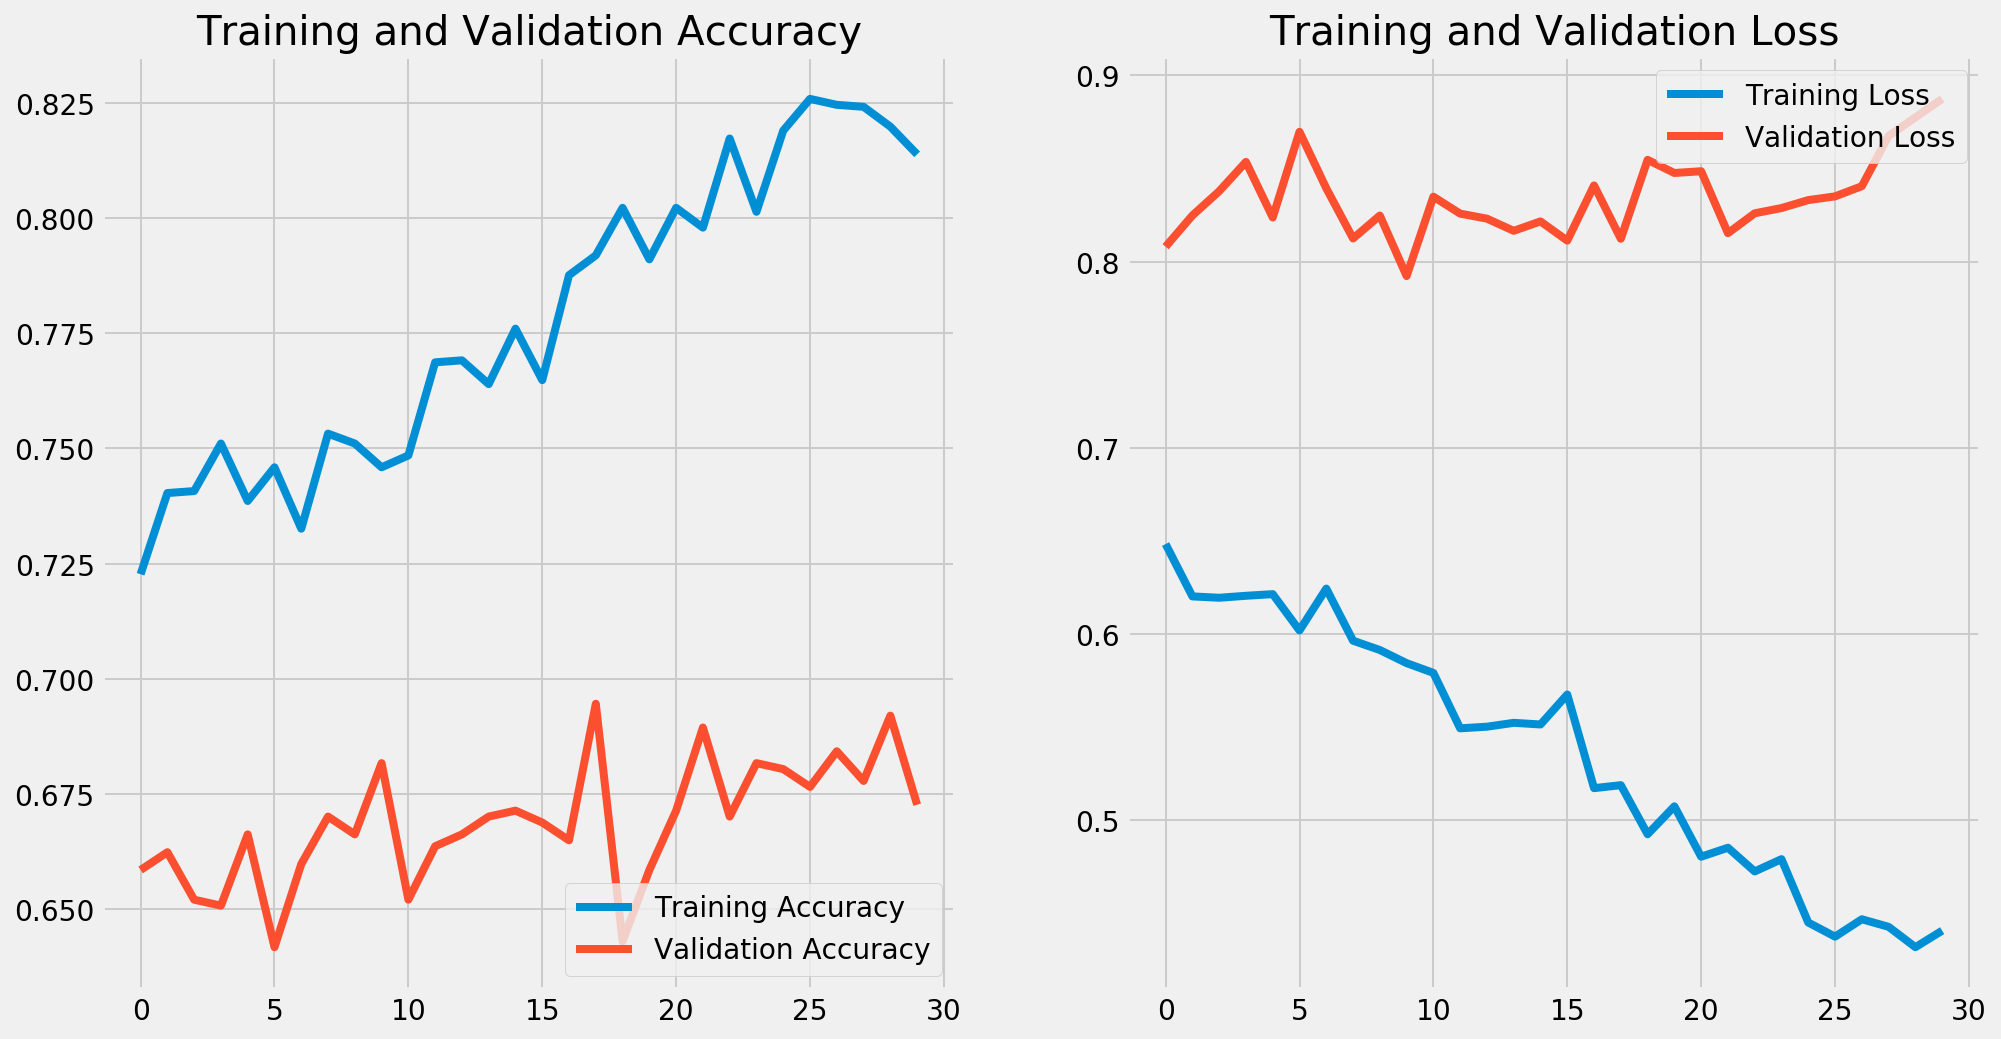

In [157]:
# plot accuracy and loss for model
plot_accuracy_loss(history, epochs = 30);
#plt.savefig("../plots/accuracy_loss_rnn.png")

## Generate predictions

In [123]:
# make predictions on test set
preds = model.predict_classes(X_test_tk)

In [124]:
val_acc = round(history.history['val_accuracy'][-1], 2)

Confusion matrix, without normalization
[[211  51  32]
 [ 48 187  50]
 [ 27  46 124]]


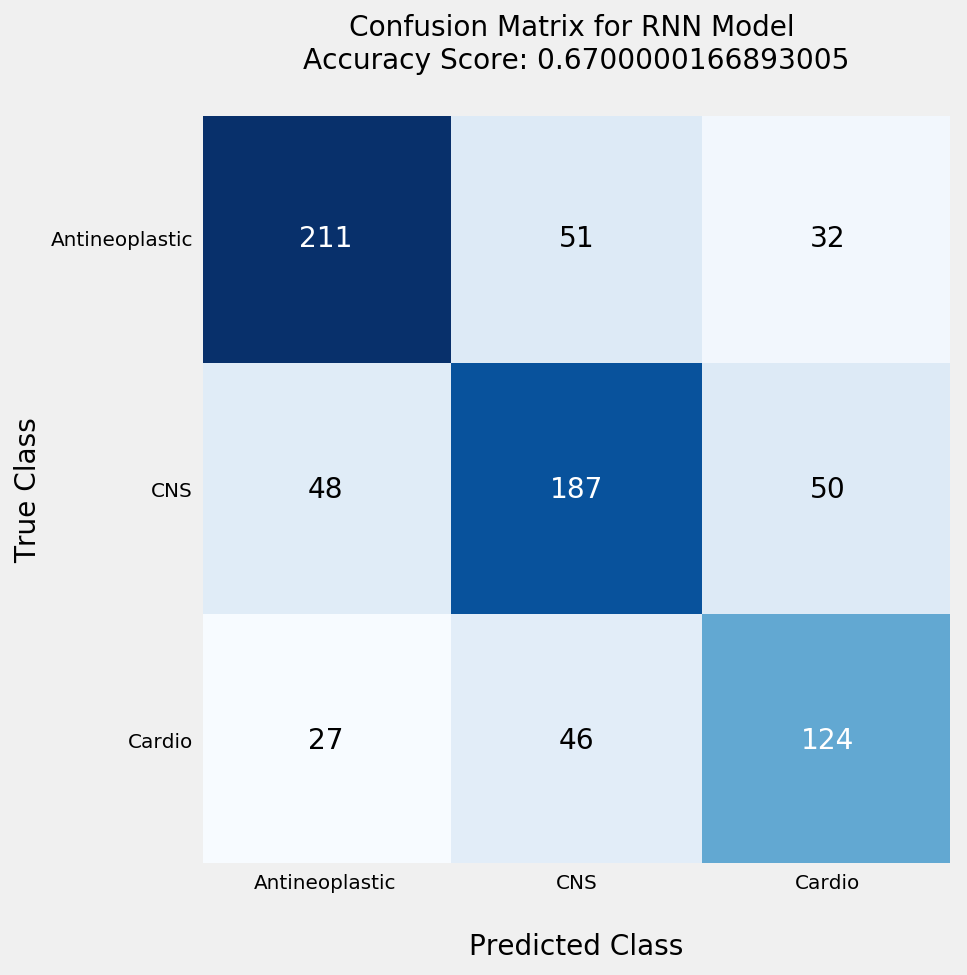

In [132]:
# Look at confusion matrix
cnf_matrix = confusion_matrix(y_test, preds,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix, classes=['Antineoplastic', 'CNS', 'Cardio'],
                      title=f'Confusion Matrix for RNN Model \nAccuracy Score: {val_acc}\n' )
plt.savefig("../plots/confusion_matrix_rnn.png", dpi = 150);